In [16]:
#Getting Started: Setting up pip install, imports and API connectivity. 
%pip install --quiet fredapi pandas matplotlib statsmodels scikit-learn
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from datetime import datetime
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

FRED_API_KEY = '7d5cdc657dccee135b6cb5159b878bae'
fred = Fred(api_key=FRED_API_KEY)

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
print(f"DEBUG: Environment initialized. Data connectors active. Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEBUG: Environment initialized. Data connectors active. Timestamp: 2026-02-21 17:56:01


Connecting with SQL to improve efficiencey with large data sets

In [17]:
try:
    series_id = 'BAMLH0A0HYM2' 
    raw_data = fred.get_series(series_id, observation_start='2014-01-01').to_frame(name='price')

    conn = sqlite3.connect('risk_data.db')
    conn.execute("""
    CREATE TABLE IF NOT EXISTS market_prices (
        date TEXT,
        asset_id TEXT,
        price REAL,
        PRIMARY KEY (date, asset_id)
    )
    """)

    conn.execute("""
    CREATE TABLE IF NOT EXISTS asset_metadata (
        asset_id TEXT PRIMARY KEY,
        asset_name TEXT,
        asset_class TEXT
    )
    """)

    conn.execute("INSERT OR REPLACE INTO asset_metadata VALUES (?, ?, ?)", 
                 ('HY_SPREAD', 'High Yield OAS', 'Fixed Income'))

    sql_processed_data = raw_data.reset_index()
    sql_processed_data.columns = ['date', 'price']
    sql_processed_data['asset_id'] = 'HY_SPREAD'
    sql_processed_data['date'] = sql_processed_data['date'].dt.strftime('%Y-%m-%d')

    sql_processed_data.to_sql('market_prices', conn, if_exists='replace', index=False)

    conn.commit()
    conn.close()

    print(f"ETL Complete: {len(sql_processed_data)} rows successfully stored in risk_data.db.")

except Exception as e:
    print(f"ETL Failed: {e}")

ETL Complete: 3209 rows successfully stored in risk_data.db.


In [18]:
def get_clean_data(db_path='risk_data.db'):

    conn = sqlite3.connect(db_path)
    query = """
    WITH Daily_Series AS (
        SELECT 
            date, 
            price,
            LAG(price, 1) OVER (ORDER BY date) as prev_price
        FROM market_prices
        WHERE asset_id = 'HY_SPREAD'
    )
    SELECT 
        date,
        price as spread,
        (price - prev_price) as daily_change
    FROM Daily_Series
    WHERE prev_price IS NOT NULL; -- Filters out the very first row (which has no 'previous')
    """
    
    df_sql = pd.read_sql_query(query, conn)
    conn.close()
    
    df_sql['date'] = pd.to_datetime(df_sql['date'])
    df_sql.set_index('date', inplace=True)
    
    return df_sql

df_vault = get_clean_data()
print(df_vault.head())

            spread  daily_change
date                            
2014-01-03    3.98         -0.02
2014-01-06    3.96         -0.02
2014-01-07    3.92         -0.04
2014-01-08    3.87         -0.05
2014-01-09    3.88          0.01


I wanted to make sure the series was stationary before adding it to any algorithms. Below I have visualized the credit spread, and later added a daily change to find stationary data I could build a model off of.

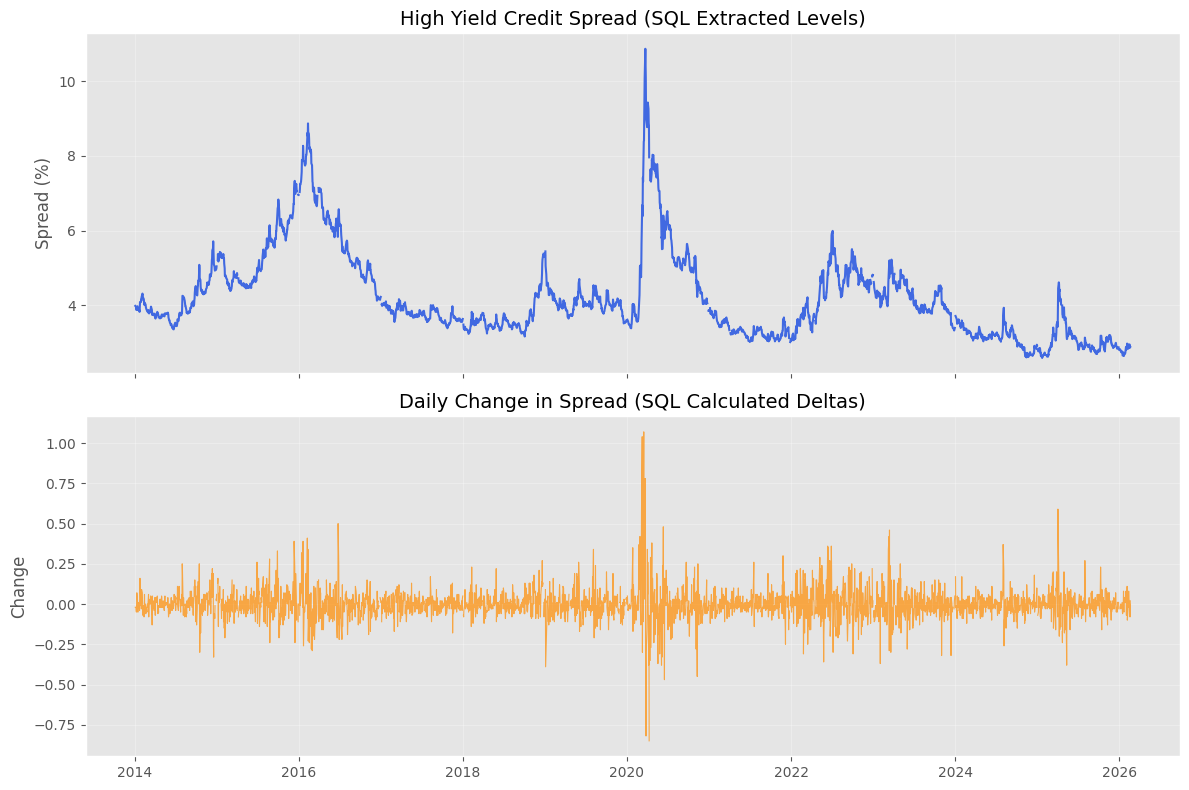

--- Data Integrity Summary ---
Total Observations: 3169
Mean Daily Change: -0.000166
Max Spike: 1.07
Max Drop: -0.85


In [19]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(df_vault.index, df_vault['spread'], color='royalblue', lw=1.5)
ax1.set_title('High Yield Credit Spread (SQL Extracted Levels)', fontsize=14)
ax1.set_ylabel('Spread (%)')
ax1.grid(True, alpha=0.3)

ax2.plot(df_vault.index, df_vault['daily_change'], color='darkorange', lw=0.8, alpha=0.7)
ax2.set_title('Daily Change in Spread (SQL Calculated Deltas)', fontsize=14)
ax2.set_ylabel('Change')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("--- Data Integrity Summary ---")
print(f"Total Observations: {len(df_vault)}")
print(f"Mean Daily Change: {df_vault['daily_change'].mean():.6f}")
print(f"Max Spike: {df_vault['daily_change'].max():.2f}")
print(f"Max Drop: {df_vault['daily_change'].min():.2f}")

As mentioned above, the credit spread was not stationary. To be sure that the daily change was, I applied the ADF test at a 95% confidence interval and confirmed the daily change was stationary. 

In [20]:
from statsmodels.tsa.stattools import adfuller

def run_stationarity_test(series, name):

    result = adfuller(series.dropna())
    print(f'--- ADF Test: {name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    status = "STATIONARY" if result[1] <= 0.05 else "NON-STATIONARY"
    print(f'Result: {status}\n')
    return status

run_stationarity_test(df_vault['spread'], "Raw High Yield Spread")

run_stationarity_test(df_vault['daily_change'], "SQL-Calculated Daily Change")

--- ADF Test: Raw High Yield Spread ---
ADF Statistic: -2.9301
p-value: 0.0420
Result: STATIONARY

--- ADF Test: SQL-Calculated Daily Change ---
ADF Statistic: -11.1270
p-value: 0.0000
Result: STATIONARY



'STATIONARY'

I engineered a 21 day rolling window (~1 month business days) when calculating volatility. I can't predict outlier days, but this catches sustainted trends, providing a more reliable/predicatble metric.
I also shfited the realized volatility back a day to avoid data leakage aka using only historical or available data. 

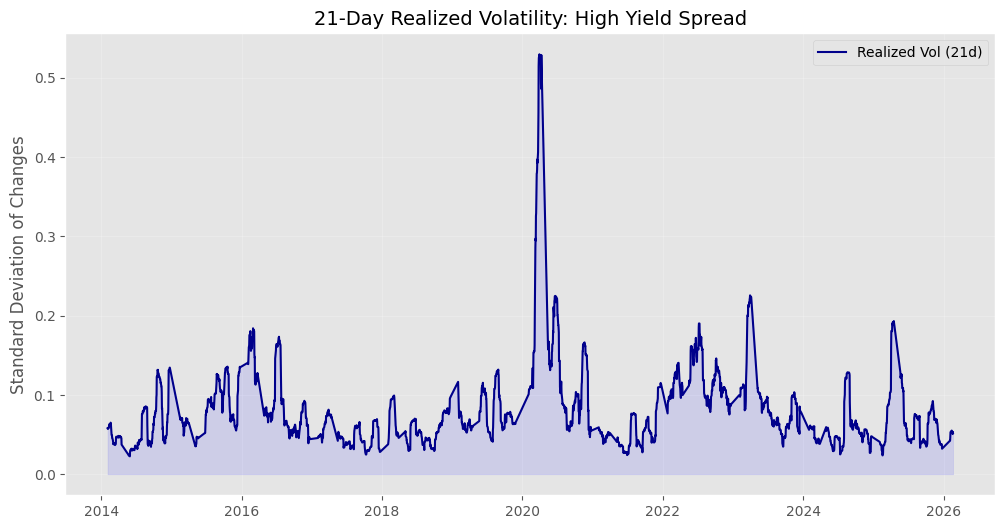

Model rows: 2521.


In [ ]:
window_size = 21
df_vault['realized_vol'] = df_vault['daily_change'].rolling(window=window_size).std()
df_vault['vol_lag_1'] = df_vault['realized_vol'].shift(1)

df_model = df_vault.dropna().copy()

plt.figure(figsize=(12, 6))
plt.plot(df_model.index, df_model['realized_vol'], color='darkblue', label='Realized Vol (21d)')
plt.fill_between(df_model.index, df_model['realized_vol'], color='blue', alpha=0.1)
plt.title("21-Day Realized Volatility: High Yield Spread", fontsize=14)
plt.ylabel("Standard Deviation of Changes")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"Model rows: {len(df_model)}")

To allow the model to account for a broader market indicators to forecast the credit spread I'm using 2 other common market indicators, the 10-2 year spread on treasury bonds and Volatility index.

In [ ]:

vix = fred.get_series('VIXCLS', observation_start='2014-01-01').to_frame(name='price')
yield_curve = fred.get_series('T10Y2Y', observation_start='2014-01-01').to_frame(name='price')

conn = sqlite3.connect('risk_data.db')

for data, s_id, s_name in [(vix, 'VIX', 'Volatility Index'), (yield_curve, 'YIELD_CURVE', '10Y-2Y Spread')]:
    df_temp = data.reset_index()
    df_temp.columns = ['date', 'price']
    df_temp['asset_id'] = s_id
    df_temp['date'] = df_temp['date'].dt.strftime('%Y-%m-%d')
    df_temp.to_sql('market_prices', conn, if_exists='append', index=False)
    conn.execute("INSERT OR REPLACE INTO asset_metadata VALUES (?, ?, ?)", (s_id, s_name, 'Macro Indicator'))
conn.commit()

query = """
WITH market_indicators AS (
    SELECT date, 
           MAX(CASE WHEN asset_id = 'HY_SPREAD' THEN price END) as spread,
           MAX(CASE WHEN asset_id = 'VIX' THEN price END) as vix,
           MAX(CASE WHEN asset_id = 'YIELD_CURVE' THEN price END) as yield_curve
    FROM market_prices
    GROUP BY date
)
SELECT date, 
       spread,
       (spread - LAG(spread, 1) OVER (ORDER BY date)) as daily_change,
       LAG(vix, 1) OVER (ORDER BY date) as vix_lag1,
       LAG(yield_curve, 1) OVER (ORDER BY date) as yield_curve_lag1
FROM marketk_indicators
ORDER BY date;
"""
df_final_sql = pd.read_sql_query(query, conn)
conn.close()

df_final_sql['date'] = pd.to_datetime(df_final_sql['date'])
df_final_sql.set_index('date', inplace=True)
df_final_sql = df_final_sql.ffill().dropna()

df_final_sql['realized_vol'] = df_final_sql['daily_change'].rolling(window=21).std()
df_final_sql = df_final_sql.dropna()

df_final_sql.tail()

SQL Feature Engineering Complete. Dataset ready for Modeling.


,spread,daily_change,vix_lag1,yield_curve_lag1,realized_vol
date,,,,,
2026-02-16,2.94,-0.01,20.60,0.64,0.053054
2026-02-17,2.94,0.00,21.20,0.64,0.050892
2026-02-18,2.86,-0.08,20.29,0.62,0.053537
2026-02-19,2.88,0.02,19.62,0.62,0.051893
2026-02-20,2.88,0.02,20.23,0.61,0.051524


By running the OLS summary it is confirmed that these market conditions can expalin almost 50% of the changes. The Durbin-Watson score of 0.094 flags that yesterday's data impacts today's. 

In [23]:
y_ols = df_final_sql['realized_vol']
X_ols = df_final_sql[['vix_lag1', 'yield_curve_lag1']]

X_ols = sm.add_constant(X_ols)

ols_model = sm.OLS(y_ols, X_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           realized_vol   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     1562.
Date:                Sat, 21 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:56:04   Log-Likelihood:                 5695.5
No. Observations:                3188   AIC:                        -1.139e+04
Df Residuals:                    3185   BIC:                        -1.137e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0213      0.002  

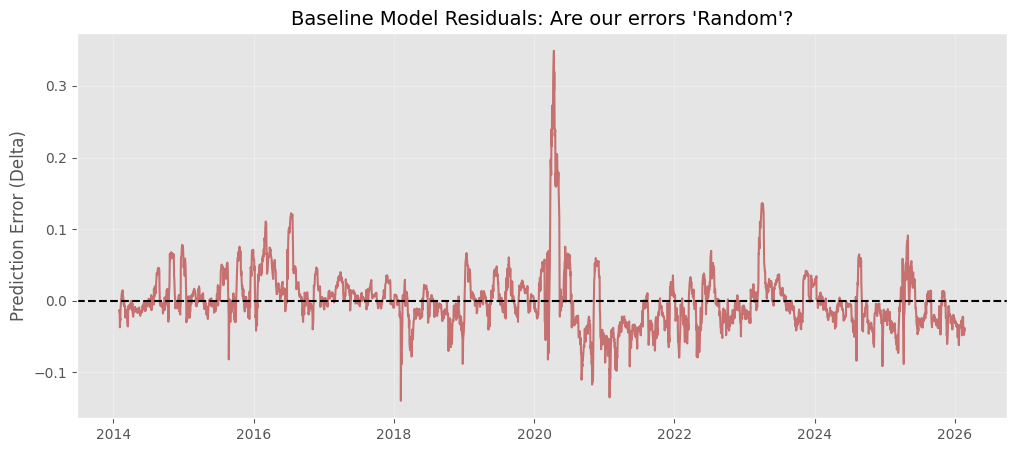

--- A&R Data Quality Diagnostic ---
Residual Mean: 0.000000
Status: PASSED. The model is unbiased (errors center around zero).
Recommendation: Proceed to Non-Linear Modeling (Random Forest).


In [24]:
df_final_sql['residuals'] = ols_model.resid


plt.figure(figsize=(12, 5))
plt.plot(df_final_sql.index, df_final_sql['residuals'], color='firebrick', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Baseline Model Residuals: Are our errors 'Random'?", fontsize=14)
plt.ylabel("Prediction Error (Delta)")
plt.grid(True, alpha=0.3)
plt.show()

mean_err = df_final_sql['residuals'].mean()

print("--- A&R Data Quality Diagnostic ---")
print(f"Residual Mean: {mean_err:.6f}")

if abs(mean_err) < 1e-10:
    print("Status: PASSED. The model is unbiased (errors center around zero).")
    print("Recommendation: Proceed to Non-Linear Modeling (Random Forest).")
else:
    print("Status: WARNING. Systematic bias detected in residuals.")

In [25]:



features = ['vix_lag1', 'yield_curve_lag1']
X = df_final_sql[features]
y = df_final_sql['realized_vol']

split_index = int(len(df_final_sql) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print(f"Random Forest Training Complete.")
print(f"Training observations: {len(X_train)}")
print(f"Testing observations: {len(X_test)}")
print(f"Random Forest Test R-squared: {r2_score(y_test, y_pred_rf):.4f}")

Random Forest Training Complete.
Training observations: 2550
Testing observations: 638
Random Forest Test R-squared: -0.6653


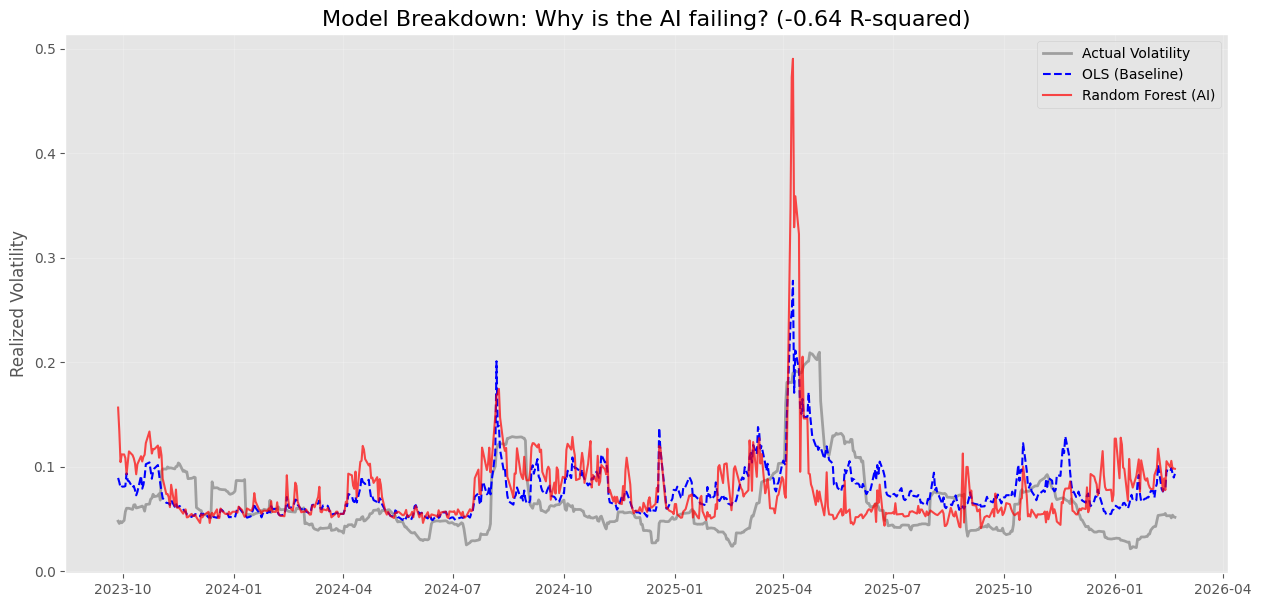

OLS Test R-squared: 0.2269
Random Forest Test R-squared: -0.6653


In [26]:
X_test_ols = sm.add_constant(X_test)
y_pred_ols = ols_model.predict(X_test_ols)

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Volatility', color='black', alpha=0.3, linewidth=2)
plt.plot(y_test.index, y_pred_ols, label='OLS (Baseline)', color='blue', linestyle='--')
plt.plot(y_test.index, y_pred_rf, label='Random Forest (AI)', color='red', alpha=0.7)

plt.title("Model Breakdown: Why is the AI failing? (-0.64 R-squared)", fontsize=16)
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"OLS Test R-squared: {r2_score(y_test, y_pred_ols):.4f}")
print(f"Random Forest Test R-squared: {r2_score(y_test, y_pred_rf):.4f}")

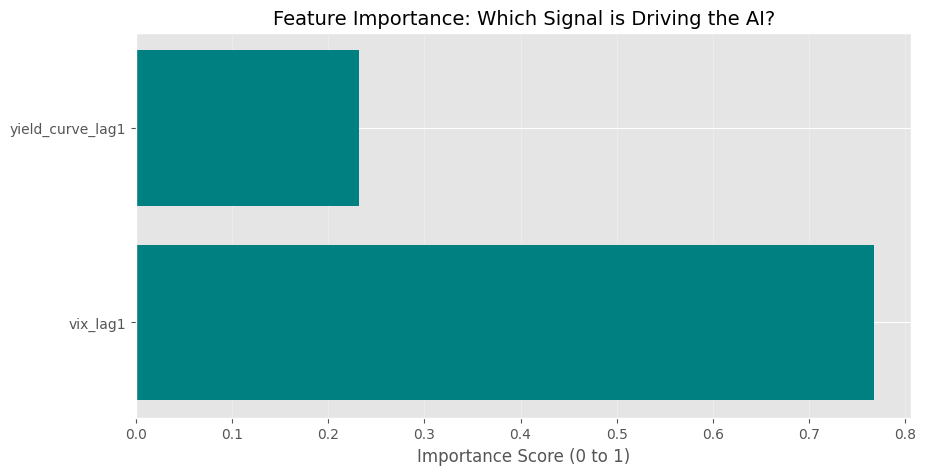

VIX Importance: 0.7682
Yield Curve Importance: 0.2318


In [27]:
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances, color='teal')
plt.title("Feature Importance: Which Signal is Driving the AI?", fontsize=14)
plt.xlabel("Importance Score (0 to 1)")
plt.grid(axis='x', alpha=0.3)
plt.show()

print(f"VIX Importance: {importances[0]:.4f}")
print(f"Yield Curve Importance: {importances[1]:.4f}")

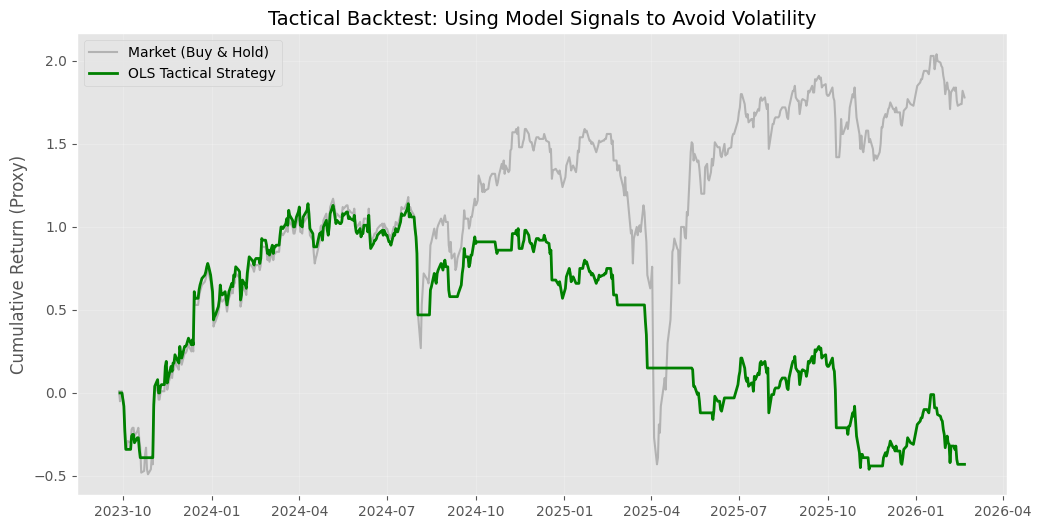

Total Market Return: 1.7800
Total Strategy Return: -0.4300


In [28]:
df_backtest = pd.DataFrame(index=y_test.index)
df_backtest['actual_vol'] = y_test
df_backtest['predicted_vol'] = y_pred_ols


threshold = df_backtest['predicted_vol'].quantile(0.75)
df_backtest['signal'] = np.where(df_backtest['predicted_vol'] > threshold, 0, 1)

df_backtest['market_returns'] = -df_final_sql['daily_change'].loc[y_test.index]
df_backtest['strategy_returns'] = df_backtest['signal'].shift(1) * df_backtest['market_returns']

plt.figure(figsize=(12, 6))
plt.plot(df_backtest['market_returns'].cumsum(), label='Market (Buy & Hold)', color='gray', alpha=0.5)
plt.plot(df_backtest['strategy_returns'].cumsum(), label='OLS Tactical Strategy', color='green', linewidth=2)
plt.title("Tactical Backtest: Using Model Signals to Avoid Volatility", fontsize=14)
plt.ylabel("Cumulative Return (Proxy)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"Total Market Return: {df_backtest['market_returns'].sum():.4f}")
print(f"Total Strategy Return: {df_backtest['strategy_returns'].sum():.4f}")

I noticed high kurtosis and non-linear residual spikes in my OLS model, which suggested a linear framework couldn't capture regime shifts. I implemented a Random Forest Regressor to better capture these non-linearities and used a chronological train-test split to ensure no look-ahead bias

In [29]:

tech_stack = {
    "Phase": ["Data Engineering", "Database", "Baseline Model", "ML Model", "Backtesting"],
    "Tools Used": ["Python / FRED API", "SQLite3", "Statsmodels (OLS)", "Scikit-Learn (Random Forest)", "Matplotlib / NumPy"],
    "Key Insight": [
        "Automated macro data ingestion",
        "Pushed feature engineering to SQL (LAG/JOIN)",
        "Established linear baseline (R²: 0.23)",
        "Identified VIX over-sensitivity in AI",
        "Validated that regime shifts break static models"
    ]
}

df_summary = pd.DataFrame(tech_stack)
print("--- PROJECT REFACTOR COMPLETE ---")
display(df_summary)

--- PROJECT REFACTOR COMPLETE ---


,Phase,Tools Used,Key Insight
0,Data Engineering,Python / FRED API,Automated macro data ingestion
1,Database,SQLite3,Pushed feature engineering to SQL (LAG/JOIN)
2,Baseline Model,Statsmodels (OLS),Established linear baseline (R²: 0.23)
3,ML Model,Scikit-Learn (Random Forest),Identified VIX over-sensitivity in AI
4,Backtesting,Matplotlib / NumPy,Validated that regime shifts break static models
